# Checkpoint 2: Convolutional neural networks and autoencoders
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)



In this checkpoint exercise we will use the Quick Draw dataset. 

The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The bitmap dataset contains these drawings converted from vector format into 28x28 grayscale images.

We will focus on a subset of 10 classes of type "body part"

The class labels are:

![listbodypart](./list_body_parts.png)

| <p align='left'> Label                   | <p align='left'> Description| 
| ---------------------------------------- | --------------------------- |
| <p align='left'> 0                       | <p align='left'> arm        |
| <p align='left'> 1                       | <p align='left'> ear        | 
| <p align='left'> 2                       | <p align='left'> eye        |  
| <p align='left'> 3                       | <p align='left'> face      | 
| <p align='left'> 4                       | <p align='left'> foot       | 
| <p align='left'> 5                       | <p align='left'> hand       | 
| <p align='left'> 6                       | <p align='left'> knee       |
| <p align='left'> 7                       | <p align='left'> leg        |
| <p align='left'> 8                       | <p align='left'> mouth      |
| <p align='left'> 9                       | <p align='left'> nose     |


Players draw items as quickly as possible, and as you can see, some images are quite bad! We will try and train a CNN classifier to anyway see if we can train a model to distinguish the classes. We will then train an autoencoder to learn a laten space representations of the dataset.

    
This week, like last, I am not providing example notebooks like `lecture2.ipynb` and `data-science-tools.ipynb` for Unit 2, though these may still be useful to you. Instead, I am **providing the imports for all of the modules and classes that you should need.** 

### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 22 October 2021** 
- This CP exercise sheet is divided into **5 sections** giving a maximum of **10 marks** in total:

| <p align='left'> Title          | <p align='left'> Exercise nos. | <p align='center'> Number of marks |
| ---------------------------------------- | --------------------- | -------------------- |
| <p align='left'> 1. Visualisation and Abstraction   | <p align='left'>   1  | <p align='left'> 1.5 |
| <p align='left'> 2. Image classification | <p align='left'> 2–5  | <p align='left'> 3.5 | 
| <p align='left'> 3. Auto-encoders        | <p align='left'> 6–9  | <p align='left'> 3.0 |
| <p align='left'> 4. Anomaly detection    | <p align='left'> 10–11| <p align='left'> 2.0 |
| <p align='left'> **Total**               |                       | <p align='left'> **10** |

---
You can find the dataset for download at [this link](https://cernbox.cern.ch/index.php/s/obvLeyMR0JEEa5p).
---
---

## Preamble
---

In [1]:
# Standard import(s)
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


In [2]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras import metrics 
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Flatten, Reshape, Conv2D,Conv2DTranspose, MaxPooling2D, AveragePooling2D, UpSampling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras import regularizers
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.python.keras.backend import set_image_data_format
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

## Data preprocessing (given, not marked)
---

First, we'll load in the preprocessed dataset from a numpy data file, which has already been split into training and testing parts for us.



* Each image has been **Reshaped to** $(N,N,1)$ dimension, i.e. image has one color dimention
* Images have been **Scaled** to have pixel intensities in the range [0,1]. It is an important step before feeding them to the neural network model, by dividing the values by 255. It's important that the training set and the testing set be preprocessed in the same way.
* Dataset was **Shuffled** for both training and testing datasets separately.
* Check the shapes of the resulting arrays; make sure they look as you expect.

In [3]:
#Load quickdraw bodyparts dataset
X_train, y_train, X_test, y_test = np.load('quickdraw_bodyparts.npy',allow_pickle=True) 


#Image labels
body_parts = ['arm', 'ear', 'eye', 'face','foot', 'hand', 'knee', 'leg', 'mouth','nose']

# Each label of the dataset correspond to a class name
class_names = body_parts

nb_train   = X_train.shape[0]
nb_test    = X_test.shape[0]
nb_classes = y_train.max() + 1
print("Number of training examples: {}".format(nb_train))
print("Number of testing  examples: {}".format(nb_test))
print("Number of target classes:    {}".format(nb_classes))

# Get image shape
shape = X_train.shape[1:]
print("Image shape:  {}".format(shape))

Number of training examples: 160000
Number of testing  examples: 40000
Number of target classes:    10.0
Image shape:  (28, 28, 1)


## Image visualisation and abstraction (1.5 marks)

#### 1. Display images of the training dataset, and check that the associated label makes sense (0.5 mark)

You will use `matplotlib.pyplot`, the `plt.imshow` method. Use the `cmap=plt.cm.binary` color map for all subsequent img plots.

1. plot 10 training dataset images, one per category. Label the images.

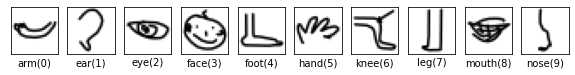

In [4]:
plt.figure(figsize=(10,10))
for i in range(len(body_parts)):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[y_train == i][0], cmap=plt.cm.binary)
    plt.xlabel("{}({})".format(class_names[i],i))
plt.show()


2. plot the fist 25 images in a 5x5 plot. Label the images.

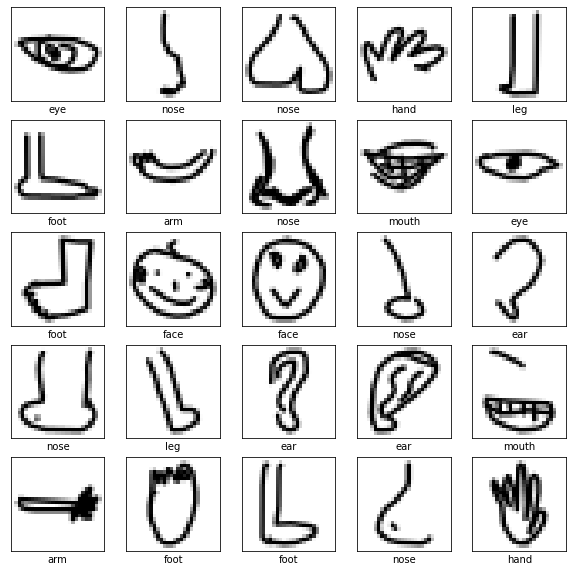

In [5]:
nb_show = 25
plt.figure(figsize=(10,10))
for i in range(nb_show):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[int(y_train[i])])
plt.show()



#### 2 Apply different kernels to an image of type face (1 mark)

1. pick an image of the face type and save it to `myface`. Plot it with `imshow` (nothing fancy needed for the plot)

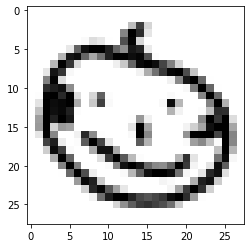

In [6]:
myface = X_train[y_train == 3][0]
plt.imshow(myface,cmap=plt.cm.binary)

2. Define 4 kernels: identity, edge_detection, sharpening, and blurring, as `3x3` numpy arrays. We add them to a dictionary of kernels.

In [7]:
k_identity = np.zeros((3,3,1))
k_identity[1,1] = 1
k_edge= np.array([[[-1],[-1],[-1]],[[-1],[8],[-1]],[[-1],[-1],[-1]]])
k_sharp= np.array([[[ 0],[-1],[ 0]],[[-1],[4],[-1]],[[ 0],[-1],[ 0]]])
k_blur = np.ones((3,3,1))/9
kernels = {"identity":k_identity,"edge":k_edge,"sharp":k_sharp,"blur":k_blur}

In [8]:
myface.shape

(28, 28, 1)

3. Given is part of the `run_kernel` function which runs over the figure and applies the kernel to every non-edge pixel. Complete the function:
    - Define the shape of the output image `np.empty(...)`
    - Define the ranges of the row and colum loops , i.e. `range(...)`
    - Define the fig index on which the kernel is multiplied in each step, ie. `fig[....]`



In [9]:
def run_kernel(fig,kernel):
    #empty array holding the output image. Define the output dimensions as excercise.
    out = np.empty((fig.shape[0]-2,fig.shape[1]-2,1))
    for i in range(fig.shape[0]-2):
        for j in range(fig.shape[1]-2):
            out[i][j] = np.sum(np.multiply(kernel,fig[i:i+kernel.shape[0],j:j+kernel.shape[1]]))
                
    return out

4. run the plotting code block below and check that the kernels are doing what you expect.
    
        Since some kernels multiply by negatives, use the norm=norm(0,1) to scale the image back to between 0 and 1 before plotting. 

In [10]:
#Import the normiliser for the bitmap
from matplotlib.colors import Normalize as norm

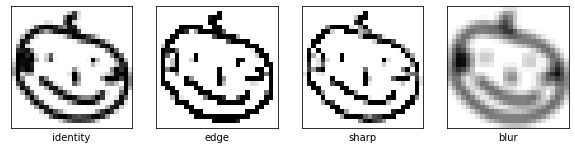

In [11]:
plt.figure(figsize=(10,10))
#Loop over kernel
for i,kernel in enumerate(kernels):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #return transformed image and plot it
    plt.imshow(run_kernel(myface,kernels[kernel]), cmap=plt.cm.binary,norm=norm(0,1))  
    plt.xlabel(kernel)
plt.show()



## Image classification (3.5 mark)
---
In this section, we will train a convolutional neural network (CNN) to perform hand-written digit recognition; a standard form of image classification. We will:
- create the model
- train the model
- evaluate its classification performance

#### 3. Define a Convolutional Neural Network suitable for image classification (1 mark).

* Use the **`Keras` functional API** to construct the model. 
* The shape of the input layer should match the shape of the prepared images.
* Add some **convolutional** and **pooling** layers in a sensible configuration. The architecture is a bit up to you, but try to reach a good level of accuracy. Around 85% on validation seems easily achievable.
    * By default, you can use $3 \times 3$ kernels, ReLU activation, and $2\times 2$ pooling; but feel free to play around with different values.
    * By default no padding is applied. You could try "same" padding in order to use the whole image, though results don't change much for me.
    * If sufferening from large overtraining 
* **Flatten** the output of the last convolutional layer.
* Connect it, to an **output** layer with the appropriate number of nodes and choice of activation function.
* Display the model architecture using the `<model>.summary()` method. Optionally display it also with the `plot_model(<model>, show_shapes=True)` method.  
* Questions:
    * _What are the number of trainable parameters in the model?_
    * _How many trainable parameters does your first convolutional layer have? Why?_
    * _Which layer has the most trainable parameters?_

In [12]:
# Connect input, intermediate, and output layers using the Keras functional API
i = Input(shape=shape)
x = Conv2D(8, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(i)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(16, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),)(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(24, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),)(x)
x = Flatten()(x)
x = Dense(20, activation='relu')(x)
o = Dense(nb_classes, activation='softmax')(x)

# Create Model
cnn = Model(i, o, name='CNN')

2021-10-24 23:28:27.679898: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


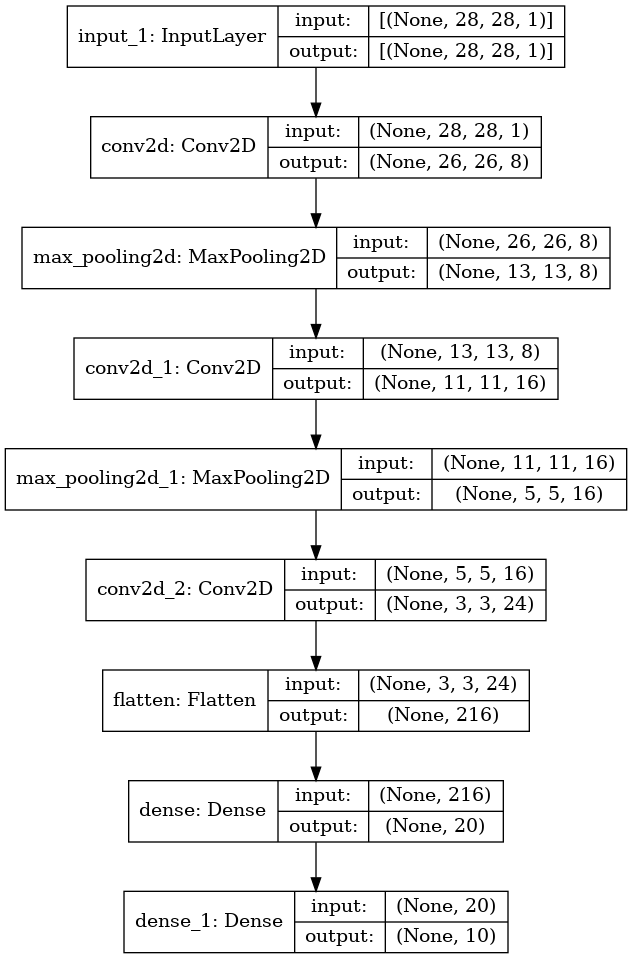

In [13]:
plot_model(cnn, show_shapes=True)

In [14]:
cnn.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 24)          3480      
_________________________________________________________________
flatten (Flatten)            (None, 216)               0       

_Indicative answers:_ Any model that maps $(28,28,1) \to (10,)$ and which has a decent testing accuracy will do.


1. The model has a total of $9726$ trainable parameters.
2. The first convolutional layer uses $8$ kernels of size $3 \times 3$. The input image has $1$ colour channel, meaning that the kernel tensor is of shape $(3,3,1)$, with $3\times 3 \times 1 = 9$ entries. This means that, with 8 distinct kernels each of which also has a bias node, the total number of parameters will be $(9 + 1) \times 8 = 80$, just as the model summary states.
3. The layer with the most trainable parameters is the first densely-connected layer in the readout ($4340$ parameters, _i.e._ almost half of all of the parameters in the model. This is illustrates how densely-connected layers require _a lot_ of parameters in constrast to convolutional layers, since the latter benefit from weight sharing.

#### 4. Compile and train the CNN image classifier (1 mark)

* Choose the appropriate loss functiton. 
* Fit for a reasonable number of epochs, use 20% of data for validation. 
* Plot the loss curve(s) by using `matplotlib.pyplot` directly with the information in the `<model>.history.history` dict.
* If you run on CPUs, stretch your legs while you wait for the 20 epoches to complete. Now is a good time for a coffee/loo break!

In [15]:
cnn.compile(optimizer='adam', 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy'])

In [16]:
history_cnn = cnn.fit(x=X_train, y=y_train, epochs=20, validation_split=0.2, batch_size=32)

2021-10-24 23:28:28.421155: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 401408000 exceeds 10% of free system memory.
2021-10-24 23:28:28.628802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-24 23:28:28.649339: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/20
3998/4000 [============================>.] - ETA: 0s - loss: 1.0827 - accuracy: 0.6567

2021-10-24 23:28:43.300078: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 100352000 exceeds 10% of free system memory.


4000/4000 [==============================] - 16s 4ms/step - loss: 1.0825 - accuracy: 0.6568 - val_loss: 0.6452 - val_accuracy: 0.7999
Epoch 2/20
4000/4000 [==============================] - 16s 4ms/step - loss: 0.6067 - accuracy: 0.8116 - val_loss: 0.5771 - val_accuracy: 0.8168
Epoch 3/20
4000/4000 [==============================] - 16s 4ms/step - loss: 0.5407 - accuracy: 0.8298 - val_loss: 0.5362 - val_accuracy: 0.8329
Epoch 4/20
4000/4000 [==============================] - 16s 4ms/step - loss: 0.5084 - accuracy: 0.8410 - val_loss: 0.5143 - val_accuracy: 0.8374
Epoch 5/20
4000/4000 [==============================] - 16s 4ms/step - loss: 0.4842 - accuracy: 0.8468 - val_loss: 0.5018 - val_accuracy: 0.8409
Epoch 6/20
4000/4000 [==============================] - 16s 4ms/step - loss: 0.4723 - accuracy: 0.8509 - val_loss: 0.4905 - val_accuracy: 0.8467
Epoch 7/20
4000/4000 [==============================] - 16s 4ms/step - loss: 0.4593 - accuracy: 0.8543 - val_loss: 0.4905 - val_accuracy: 0.8

In [17]:
X_train.shape

(160000, 28, 28, 1)

In [18]:
o.shape

TensorShape([None, 10])

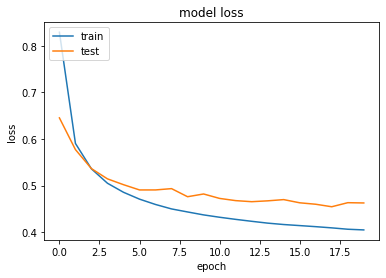

In [19]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 5. Evaluate the classification performance on the testing dataset (1 Mark)

* Compute the testing accuracy, _e.g._ using the `<model>.evaluate()` method. Compare to the training accuracy; can be read off from fit printout, if you added the `'accuracy'` metric, or can be calculated here.
* Display a few mis-classified images from the test dataset.
    * For this you will need to use the model to predict from the testing features.
    * This yields arrays of 10 probabilities, 1 per class. Get the index from maximum probability to find the class prediction. Maybe consider using `argmax`?
* Compute and display the confusion matrix (normalise by truth label). Discuss the results.

In [20]:
# Evaluating performance on test dataset
_, acc = cnn.evaluate(X_test, y_test)
print("Testing accuray: {:.1f}%".format(acc * 100.))

  93/1250 [=>............................] - ETA: 1s - loss: 0.4840 - accuracy: 0.8545

2021-10-24 23:34:02.731329: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 125440000 exceeds 10% of free system memory.


1250/1250 [==============================] - 2s 2ms/step - loss: 0.4695 - accuracy: 0.8561
Testing accuray: 85.6%


2021-10-24 23:34:04.917557: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 125440000 exceeds 10% of free system memory.


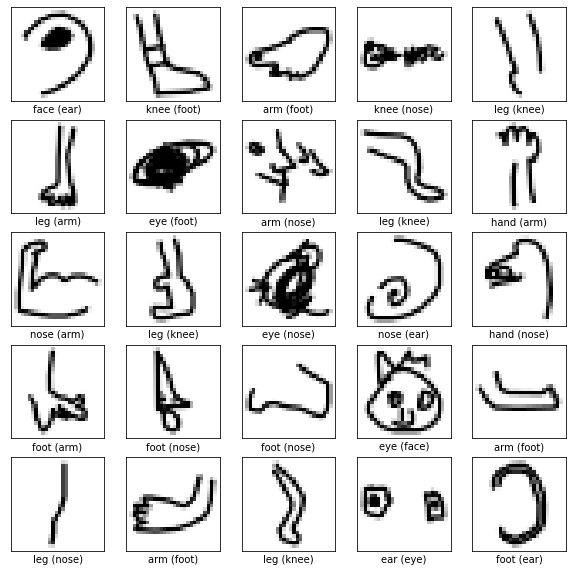

True  label: [1. 4. 4. 9. 6. 0. 4. 9. 6. 0. 0. 6. 9. 1. 9. 0. 9. 9. 3. 4. 9. 4. 6. 2.
 1.]
Pred. label: [3 6 0 6 7 7 2 0 7 5 9 7 2 9 5 4 4 4 2 0 7 0 7 1 4]


In [21]:
# Show some examples of misclassifications
# Predict the probabilities of 10 classes
p_test   = cnn.predict(X_test)
#Pick the index of the highest class per image
py_test  = p_test.argmax(axis=-1)
#Check where the prediction fails to match the target
ix_wrong = np.where(py_test != y_test)[0]

plt.figure(figsize=(10,10))

for i in range(nb_show):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[ix_wrong[i]], cmap='Greys')
    plt.xlabel("{} ({})".format(class_names[py_test[ix_wrong[i]]],
                                class_names[int(y_test[ix_wrong[i]])]))
plt.show()

print("True  label: {}".format(y_test[ix_wrong[:nb_show]]))
print("Pred. label: {}".format(py_test[ix_wrong[:nb_show]]))

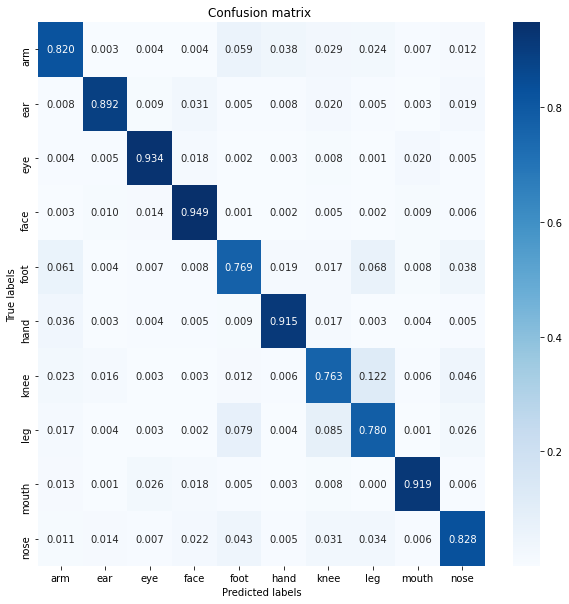

In [22]:
cm = confusion_matrix(y_test, py_test, normalize="true")
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, cmap=plt.cm.Blues,annot=True,fmt=".3f")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
ax.set_yticklabels(body_parts)
ax.set_xticklabels(body_parts)
plt.title('Confusion matrix ')
plt.show()

_Indicative answer:_ The testing accuracy is $85\%$, which is slightly less than the training accuracy of $87\%$. This is consistent with the plotted loss curves. This shows that classificaton performance generalises well to the testing dataset, and that at least the CNN is not overfitting the data. Without regularisation the conclusions may be different. Consider reasoning in their explenation.

The misclassified images seem pretty reasonable; those are ones that I might also have struggled with since people have varying degrees of aptitude for drawing. Oarticulary hand vs foot distinction seems difficult.

Finally, the confusion matrix quite good on the diagonal, around half over 90% — that's great considering how horrible some drawings are! The off-diagonal elements with the largest values are _e.g._ leg vs knee and foot. Not surprising since many people draw the whole leg when drawing a knee or foot. 

For your own interest (not marked) run the first layer kernels over `myface`. You should see several copies of the image, all with varying transformations. In your training you may find different kernels, but I can clearly spot a bluring kernel in my first layer.

In [23]:
myface.shape

(28, 28, 1)

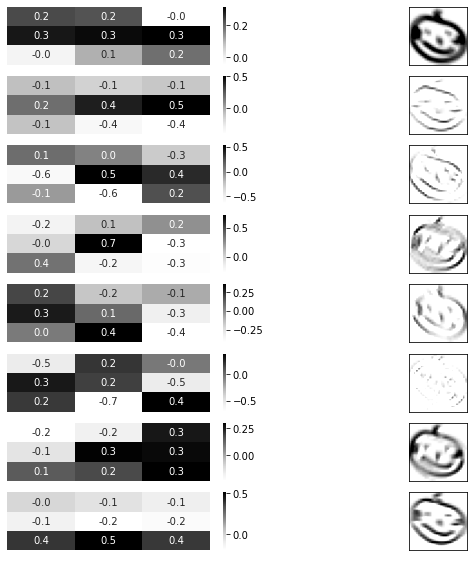

In [24]:
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(8,2,2*(i)+1)

    sns.heatmap(cnn.layers[1].get_weights()[0][:,:,:,i][:,:,0], cmap='Greys',annot=True,fmt=".1f")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.subplot(8,2,2*i+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(run_kernel(myface,cnn.layers[1].get_weights()[0][:,:,:,i]),cmap=plt.cm.binary,norm=norm(0,1))
plt.show()


## Auto-encoders (3 marks)
---
In this section, we will construct and train an auto-encoder as an example of **unsupervised learning.** This type of model is made up of an **encoder** that maps an image of shape $(N,M,C)$ into a latent vector of shape $(L,)$; and a **decoder** which maps the latent vector into an image with the same shape as the original. The latent, or encoded, vector will typically be small in size compared to the input image (_i.e._ $L \ll N \times M \times C$), meaning that it is an **information bottleneck.** The aim of the auto-encoder is therefore to learn the most efficient encoding of a class of images (here: quickdraw dataset) that allows the decoder to reconstruct the original as well as possible under the bottleneck constraint.

We will break down this task into a few sub-tasks, to make it easier to get through.

#### 6. Construct the encoder (1 Marks)

* Use the `Keras` functional API to construct the encoder model. 
* The shape of the input layer should match the shape of the prepared images .
* Add some convolutional and pooling layers in a sensible configuration. 
    * Using a decreasing number of kernels for each convolutional layer (_e.g._ $16 \to 8 \to 4 \to 2 \to 1$) works quite well.
    * For this task it is worthwhile to give some thought to padding: You want to have intermediate layers with shapes that are easy to reconstruct with the decoder. As a starting point, consider using `padding='same'` for your conv. layers.
    * **See also the note below.**
* Flatten the output of the last convolutional layer, and use this as the latent vector. 
    * For convenience, we choose to make the latent vector have values in the range [0,1], so add the appropriate activation function to the preceeding convolutional layer.
* Display the model architecture using the `<model>.summary()` method, optionally also the `plot_model(<model>, show_shapes=True)` method.
    * These methods are also very useful for debugging, when you are building your network. For instance, start with the simplest possible `Keras` model; plot the architecture using one of these methods; modify the model slightly; plot the architecture again to see the effect; _etc._
    * Make sure that the output of the encoder is indeed a bottleneck, _i.e._ that the number of output nodes is significantly smaller than the number of pixels in the image. (_Hint: A latent vector could have size $49 \ll 28 \times 28 \times 1 = 784$._)
    
**Note:** Choosing the architecture for an auto-encoder can be a bit tricky. The input images we use have shape $(28,28,1)$, and when we're pooling we typically downsample by a factor of $2$. If we use "same" padding, this means that we can go down to $(7,7,F)$ with no issues. However, if we downsample further (_e.g._ $7\to 3$) it will be tricky for the decoder to reconstruct, since upsampling would result in $3\to 6$. Therefore, to keep things simple, it may be best to not downsample further than $(7,7,F)$. However, you can still add _multiple convolutional layers in a row without pooling._

In [25]:
i = Input(shape=shape, name='input')
x = i
x = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D( 8, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D( 4, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D( 2, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D( 1, kernel_size=(3,3), padding='same', activation='relu')(x)
e = Flatten()(x)

encoder = Model(i, e, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 2)           74  

#### 7. Construct the decoder (1 Mark)

* Use the `Keras` functional API to construct the decoder model. 
* **Reshape** the latent vector to have the shape of the last convolutional layer in the encoder.
* The shape of the input layer should match the shape of the latent vector.
* Add some convolutional and **upsampling** layers in a sensible configuration. 
    * You can use the same order of kernels (_e.g._ $16 \to 8 \to 4 \to 2 \to 1$) as in the encoder.
    * Many of the notes and considerations mentioned for the encoder hold for the decoder as well.
* The output of the decoder should have the same shape as the number images. Also, choose an output activation that is appropriate to the dataset.
* Display the model architecture using the `<model>.summary()` method, optionally also the `plot_model(<model>, show_shapes=True)` method.
    * As for the encoder, these methods can be very useful for debugging.

In [26]:
encoding_shape = encoder.layers[-2].output_shape[1:]  # Otherwise, it is fine to hard-code this shape/size

# Define convolutional decoder model
t = Input(shape=(np.prod(encoding_shape),))
x = Reshape(encoding_shape)(t)
x = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(8, kernel_size=(3,3), padding='same', activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(4, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(2, kernel_size=(3,3), padding='same', activation='relu')(x)
o = Conv2D(1, kernel_size=(3,3), padding='same', activation='sigmoid')(x)               
decoder = Model(t, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 16)          160       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 4)         292 

#### 8. Construct the auto-encoder (given, not marked)

Connecting the encoder and decoder to form the auto-encoder is a slightly tricky use of the `Keras` functional API, so I'll just give that to you. Assuming you have given you encoder and decoder intuitive names, the following should do the trick:

In [27]:
i   = encoder.input
cae = Model(i, decoder(encoder(i)), name='ConvAE')
cae.summary()

Model: "ConvAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 49)                1705      
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         1705      
Total params: 3,410
Trainable params: 3,410
Non-trainable params: 0
_________________________________________________________________


Try to make sure that you understand what is going on here: In the `Keras` functional API, layers and even entire models work like functions (thus the name). What we're doing above is passing an input image `i` through the encoder (resulting in a latent vector); passing the output of `encoder` as the input to `decoder` (resulting in a reconstructed image); and finally using the output of `decoder` as the output of the auto-encoder.

#### 9. Compile and train the auto-encoder (1 Mark)

* Choose an appropriate loss function.
* Train for ca. 10 epochs with some data held out for validation. Time for another coffee break!
* Plot the loss curve(s).
* Perform the auto-encoding for the testing images (use the `<model>.predict()` method) and display the first couple of _(a)_ original and _(b)_ auto-encoded images to see whether the outputs resembles the original images.

In [28]:

cae.compile('adam', loss='binary_crossentropy',metrics=['accuracy'])
history_cae = cae.fit(x=X_train, y=X_train, epochs=10, validation_split=0.2, batch_size=32)

2021-10-24 23:34:09.529616: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 401408000 exceeds 10% of free system memory.


Epoch 1/10
4000/4000 [==============================] - 60s 15ms/step - loss: 0.2522 - accuracy: 0.7561 - val_loss: 0.1814 - val_accuracy: 0.7735
Epoch 2/10
4000/4000 [==============================] - 60s 15ms/step - loss: 0.1777 - accuracy: 0.7751 - val_loss: 0.1684 - val_accuracy: 0.7783
Epoch 3/10
4000/4000 [==============================] - 61s 15ms/step - loss: 0.1661 - accuracy: 0.7789 - val_loss: 0.1598 - val_accuracy: 0.7803
Epoch 4/10
4000/4000 [==============================] - 60s 15ms/step - loss: 0.1582 - accuracy: 0.7804 - val_loss: 0.1543 - val_accuracy: 0.7809
Epoch 5/10
4000/4000 [==============================] - 61s 15ms/step - loss: 0.1538 - accuracy: 0.7812 - val_loss: 0.1517 - val_accuracy: 0.7814
Epoch 6/10
4000/4000 [==============================] - 60s 15ms/step - loss: 0.1519 - accuracy: 0.7813 - val_loss: 0.1507 - val_accuracy: 0.7815
Epoch 7/10
4000/4000 [==============================] - 62s 15ms/step - loss: 0.1505 - accuracy: 0.7816 - val_loss: 0.1497 -

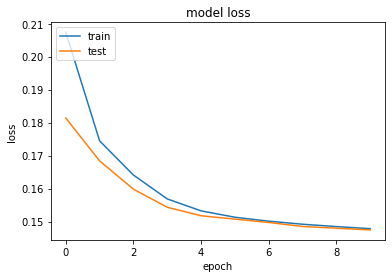

In [29]:
plt.plot(history_cae.history['loss'])
plt.plot(history_cae.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
p_test = cae.predict(X_test)

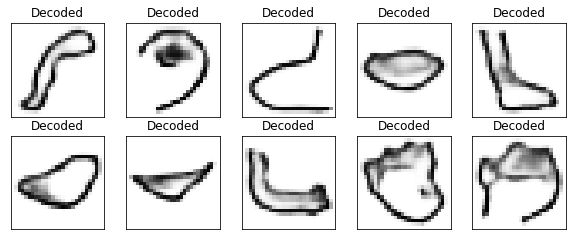

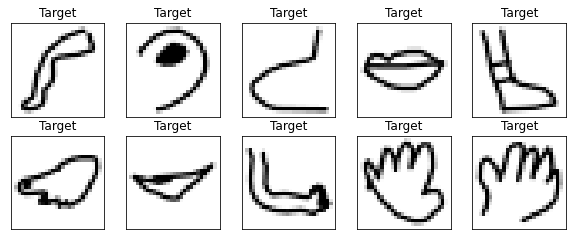

In [31]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(p_test[i], cmap='Greys')
    plt.title('Decoded')
plt.show()

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap='Greys')
    plt.title('Target')
plt.show()

_Comments_: 

* Since we have scaled the images to have pixel values in the range [0,1], we can use binary cross-entropy loss and essentially treat the pixels intensitites as probabilities. Alternatively, we can use the standard loss for regression: mean squared error loss. Both will train the auto-encoder output to be as close to the original image as possible, so both are valid options.
* From visual inspection of a few auto-encoded images, we can see that the model works as intended for simple figures: The transformed images are imperfect reconstructions of the original images. This shows us that the auto-encoder does its job, but that the information bottleneck of the latent space means that some resolution is lost in the encodering (just as it should be).

#### 10. Predict 10 images into the laten space using the encoder only. Reshape the output to images and plot the laten space images.

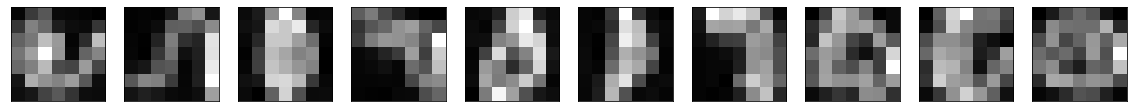

In [32]:
encoded_imgs = encoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((7, 7)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Anomaly detection (2 marks)
---

We have introduced auto-encoders as a form of unsupervised learning, since we are not using the image labels during training. This means that auto-encoders are not ideal for image classification (at least not since we actually _have_ the labels), but they can be used for something else: anomaly detection. This is the task of identifying examples that the model considers "anomalous" with respect to the dataset used during training. 

First, we'll load in some "anomalous" data:

In [33]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces(shuffle=True)['images']
faces = faces[:,4:-4:2,4:-4:2,np.newaxis]

#### 9. Inspect the face images and the auto-encoder result (1 mark)

* How many samples does the "outlier" dataset (_i.e._ `faces`) contain?
* What is the shape of the images and what is the range of pixel intensities? Does this conform with the preprocessed quickdraw images?
* Display the first few face images.
* Get the output/prediction of the auto-encoder from the previous section when applied to all of the faces.
* Show the auto-encoded versions of the same faces you showed above. Discuss the results.

Number of images: 400
Shape: (28, 28, 1)
Pixel intensity range: [0.020661156624555588, 0.9710744023323059]


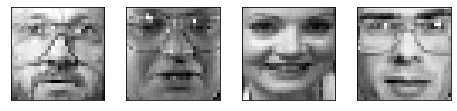

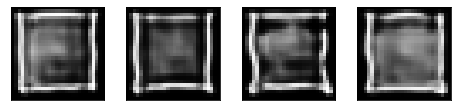

In [34]:
print("Number of images:",faces.shape[0])
print("Shape:",faces.shape[1:])
print("Pixel intensity range: [{}, {}]".format(faces.min(), faces.max()))
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(faces[i])
plt.show()

p_face = cae.predict(faces)

plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(p_face[i])
plt.show()


_Indicative answers:_
    
* The face images have the same shape and pixel intensity range as the preprocessed quickdraw images, so they are valid inputs to the auto-encoder.
* We can see that the auto-encoder transformed faces are _very_ unlike the input images. This is because the auto-encoder was trained to learn an efficient representation of hand-written digits which is not necessarily an efficient representation for other image domains, _e.g._ faces. This examples shows that this is clearly the case. From the point of view of the auto-encoder, images of faces are _anomalies_ in that they are fundamentally unlike the images on which it was trained, and therefore we shouldn't expect it to do a good job in encoding them.

#### 11. Perform anomaly detection (1 mark)
Imagine now that we had a dataset comprised of mostly quickdraw images, but also a small subset of anomalies or "outliers"; here, in the form of black-and-white images of faceses, with the same shape as the quickdraw images.

In [35]:
# Combined MNIST images and "outliers" in a mixed dataset
mixed = np.vstack((X_test, faces))

# Shuffle the mixed dataset so the "outliers" are randomly distributed
indices = np.random.permutation(mixed.shape[0])
mixed   = mixed[indices]

In [36]:
p_mixed = cae.predict(mixed)

In [37]:
eps = np.finfo(float).eps
print(np.clip(p_mixed, eps, 1. - eps).min())
print(p_mixed.min())

2.220446e-16
5.241603e-23


The auto-encoder was trained to minimise the difference between the original and the auto-encoded image, so let's use binary cross-entropy (BCE) as our metric for the difference between an image and its auto-encoded version. The `binary_crossentropy` method provided below computes **pixel-wise BCE** for two (arrays of) images: the input and the output image.

In [38]:
def binary_crossentropy (img_in, img_out):
    assert img_in.shape == img_out.shape
    eps = np.finfo(float).eps
    img_out = np.clip(img_out, eps, 1. - eps)
    return - (img_in * np.log(img_out) + (1 - img_in) * np.log(1 - img_out))

In [39]:
m = metrics.BinaryCrossentropy()

In [40]:
from sklearn.metrics import log_loss

In [41]:
log_loss

<function sklearn.metrics._classification.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)>

In [42]:
def difference (img_in, img_out):
    return binary_crossentropy(img_in, img_out).mean(axis=(1,2,3))

In [43]:
binary_crossentropy(mixed, p_mixed).shape

(40400, 28, 28, 1)

In [44]:
binary_crossentropy(mixed, p_mixed).mean(axis=(3))


array([[[3.95197276e-04, 1.19209304e-07, 0.00000000e+00, ...,
         1.72853629e-06, 4.35114862e-06, 4.51217347e-05],
        [3.57627925e-07, 0.00000000e+00, 0.00000000e+00, ...,
         1.07288417e-06, 5.96046618e-07, 1.78813963e-07],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.48097165e-05, 1.81199757e-05, 6.02008731e-06],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.26497900e-06, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 5.96046519e-08]],

       [[8.53877515e-03, 1.09738168e-04, 1.43597892e-04, ...,
         4.17232599e-07, 4.29154352e-06, 1.85149169e-04],
        [6.22009533e-03, 4.63623041e-03, 5.35399094e-02, ...,
         0.00000000e+00, 5.96046519e-08, 1.78814093e-06],
        [3.57275899e-03, 

---
* Define a new method called `difference` which takes as input two arrays of images (`img_in` and `img_out`; similar to the `binary_crossentropy`); computes the **average BCE value for each image,** or row; and returns a vector of these difference measures.
* For each image, or row, in `mixed`, compute the difference score of the auto-encoded image wrt. the original image. This is a measure of how "inlier"- or "outlier"-like an image is.
* Make a histogram of these scores, and see if you can identify any structure. It might be useful to use a logarithmic x-axis (see `plt.xscale`) along with logarithmic x-axis bins (see `np.logspace`).
* Show the 9 least and the 9 most outlying images, according to this difference score. Discuss the results.

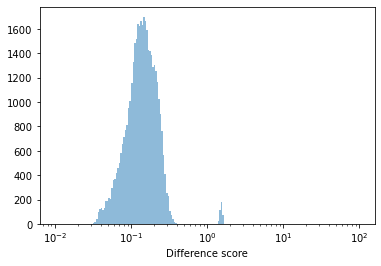

In [45]:
def difference (img_in, img_out):
    return binary_crossentropy(img_in, img_out).mean(axis=(1,2,3))

p_mixed = cae.predict(mixed)
score   = difference(mixed, p_mixed)

bins = np.logspace(-2, 2, 200+1)
plt.hist(score,   bins=bins, alpha=0.5);
plt.xscale('log')
plt.xlabel('Difference score');

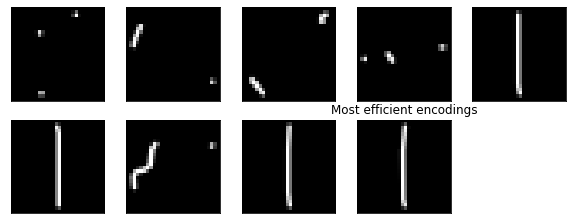

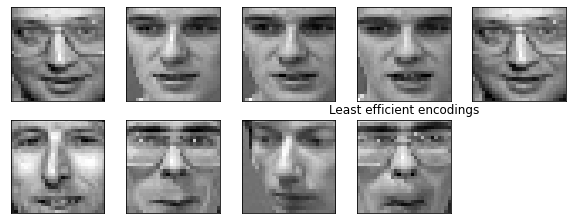

In [46]:
sorted_indices_scores = sorted(zip(np.arange(score.size), score), key=lambda p: p[1])

best_indices  = list(list(zip(*sorted_indices_scores[:9]))[0])
worst_indices = list(list(zip(*sorted_indices_scores[-9: ]))[0])

plt.figure(figsize=(10,10))

for i in range(len(best_indices)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mixed[best_indices[i]])
plt.title("Most efficient encodings");
plt.show()

plt.figure(figsize=(10,10))
for i in range(len(worst_indices)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mixed[worst_indices[i]])
plt.title("Least efficient encodings");
plt.show()


_Indicative answer:_ From the histogram of difference scores we clearly se two peaks: One, the most populous, with very low (_i.e._ good) difference scores, and one with very large (_i.e._ bad) difference scores. The latter are considered the outliers, and the former the inliers. When we plot the most inlier-like and the most outlier-like images, it is clear that simple lines are very easy for the auto-encoder to encode efficiently, whereas (as we suspected) images of faces are consistently poorly reconstructed. _This means that if someone shuffled a few faces into you neat pile of hand-written digits, you would be able to automatically pick them out with very large confidence!_

In [51]:
z_random = np.random.rand(16, np.prod(encoding_shape))
gen= decoder.predict(z_random)

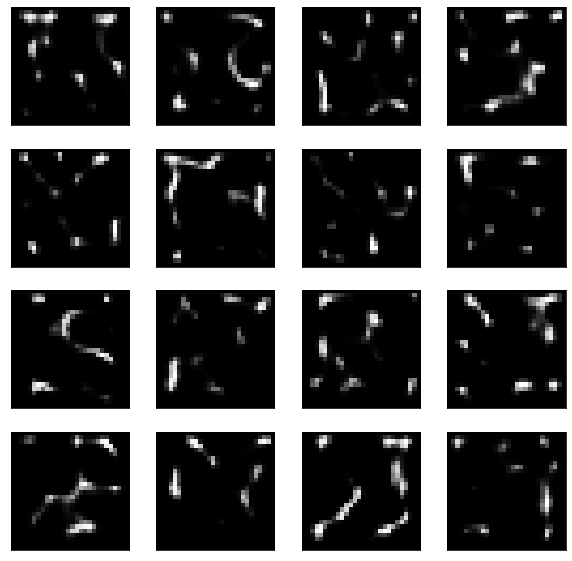

In [54]:
plt.figure(figsize=(10,10))
for i,img in enumerate(gen):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)